# Analysis of Neutron Diffraction Data

This notebook can be foun in the github repo:
https://github.com/gcsantucci/SMC_DataChallenge_Diffraction/blob/master/figs/analysis.md

This is part of a data science challenge promoted by Oak Ridge National Lab. See more here:

https://smc-datachallenge.ornl.gov/

This particular challenge is described in more details here:

https://smc-datachallenge.ornl.gov/2017/challenge-4/

The main idea of this challenge is to be able to detect phase transitions in a material by looking at curves of intensity as a function of distance (characteristical spacingof the material).
The strategy is to look for peaks of intensity at a given temperature, count the number of peaks and characterize them (area, center and width). Then, by doing the same analysis at the adjacent temperatue, we can study if the peak structure changed due to a phase transition.

In [1]:
%matplotlib inline  
import os
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec, pylab
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy.integrate import quad
from visuals import *
from peaks import *

Change file location accordingly:

In [2]:
path = '/Users/santucci/Dropbox/DataScience/SMC_DataChallenge'
infile = 'data/Powder_Diffraction.nxs'
infile = os.path.join(path, infile)

Read the file and inpect it:

In [3]:
f = h5py.File(infile, 'r')

In [4]:
for i in f:
    print(i)

entry


In [5]:
for i in f['entry']:
    print(i)

data


In [6]:
for i in f['entry']['data']:
    print(i)

Q
dspacing
intensity
temperature


Let's define the necessary arrays that will be used in our analysis:
- ds: Since dspacing (Angstrom) is an array containing the bin edges, we can define a new array contaning the bin centers to plot our data.
- I: The intensities 2d-array, containing all the intensity values for a given temperature T: I[T][i]
- T: The corresponding temperature (Kelvin) array.

In [7]:
ds = np.array(f['entry']['data']['dspacing'])
ds = (ds[:-1] + ds[1:]) / 2
I = np.array(f['entry']['data']['intensity'])
T = np.array(f['entry']['data']['temperature'])
f.close()   # closing the file, since we got all the data!

The GetPeaks function below is a simplified version of a matlab based peak detection algorithm (insert reference here!!).
This is one of the key parts of our algorithm. The way it works is basically we say that all points in the data are peaks, then we remove all of the points that are below some threshold (user input), and then we remove points that are too close to other peaks (user input).

The full algorithm can also look for valleys (by negating the data) and more complicated peak structure. But we have simplified the function since the data structure that we have is simpler.

### Inspecting the data:

Let's look at a few curves I(d) for random values of temperature to get familiarized with the data:

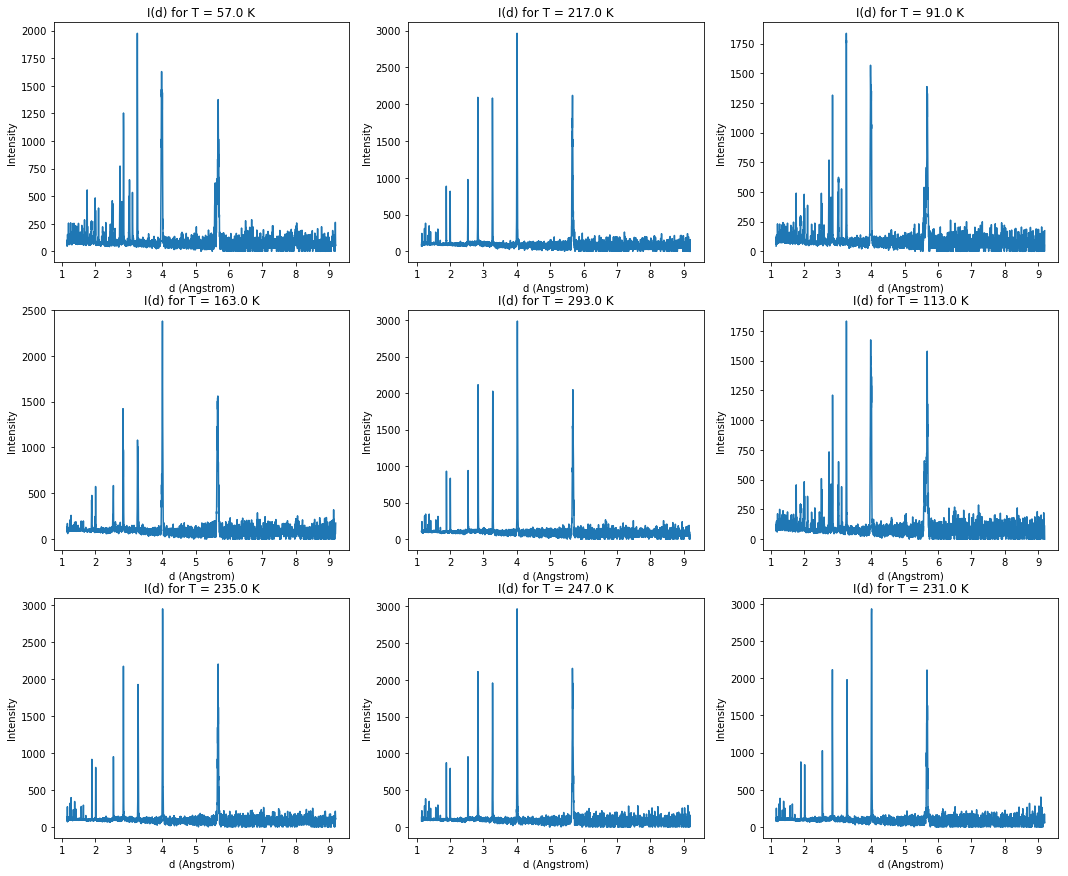

In [8]:
ncols = 3
nrows = 3
nfigs = ncols * nrows

fig = plt.figure(1, figsize=(6*ncols, 5*nrows))
for ifig in range(nfigs):
    itemp = np.random.randint(len(T))
    plt.subplot(nrows, ncols, ifig+1)
    plt.title('I(d) for T = {} K'.format(round(T[itemp]),2))
    plt.plot(ds,I[itemp])
    plt.xlabel('d (Angstrom)')
    plt.ylabel('Intensity')
plt.show()

# Characterization of the 3.25 A Peak

Let's study the peak between 3.2 and 3.3 A for all temperatures. Namely, let's look at the center of the peak (d spacing coordinate), the area under the peak and a typical width.

Let's concentrate in the (3.2,3.3) A region:

In [9]:
def CharacterizePeaks(dsmin, dsmax):
    X = ds[np.argwhere((ds>dsmin)&(ds<dsmax))].flatten()
    Y = np.array([i[np.argwhere((ds>dsmin)&(ds<dsmax))].flatten() for i in I])

    AreaPeak = []
    MeanPeak = []
    WidthPeak = []
    BkgPeak = []
    AvgPeak = []
    LSEPeak = []

    for temp, y in enumerate(Y):
        area, mean, sigma = GetSeed(X, y)
        bkg, err = GetBkg(I[temp])
        popt, pcov = curve_fit(gaus_b, X, y, p0=[area, mean, sigma, bkg])
        A, x0, sigma, b = popt
        Yhat = np.array([gaus_b(x, A, x0, sigma, b) for x in X])
        res = Yhat - y
        AreaPeak.append(A)
        MeanPeak.append(x0)
        WidthPeak.append(sigma)
        BkgPeak.append(b)
        AvgPeak.append(y[np.argwhere(X<3.24)].flatten().mean())
        LSEPeak.append(LSE(X, y, A, x0, sigma, b, err))

    AreaPeak = np.array(AreaPeak)
    MeanPeak = np.array(MeanPeak)
    WidthPeak = np.array(WidthPeak)
    BkgPeak = np.array(BkgPeak)
    AvgPeak = np.array(AvgPeak)
    LSEPeak = np.array(LSEPeak)
    return X, Y, AreaPeak, MeanPeak, WidthPeak, BkgPeak, AvgPeak, LSEPeak

In [10]:
X, Y, AreaPeak, MeanPeak, WidthPeak, BkgPeak, AvgPeak, LSEPeak = CharacterizePeaks(3.2, 3.3)

After fitting a gausian+background to all 3.25 A peaks (for all temperatures), we can look at the distribution of area, center and width for these different temperatures:

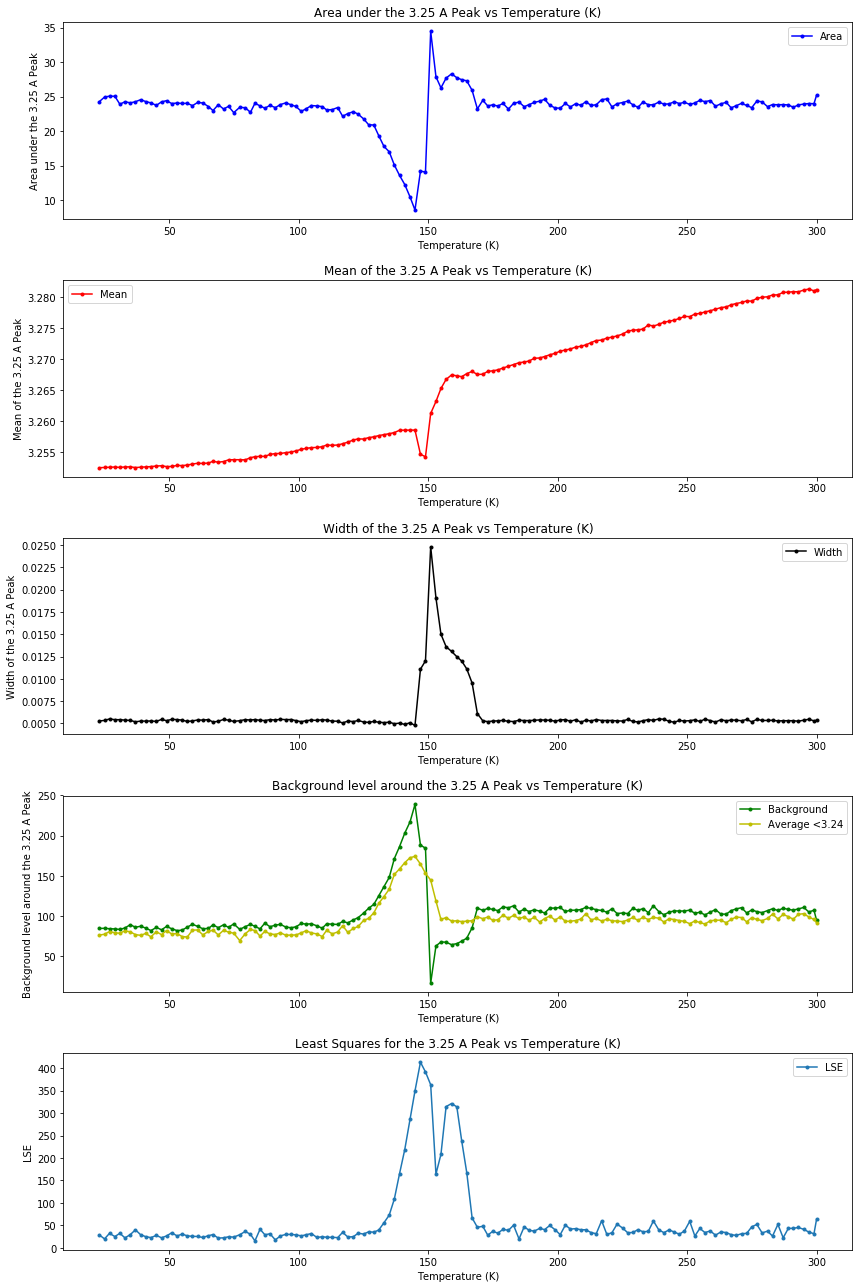

In [11]:
fig = plt.figure(5, figsize=(12,18))

ax1 = plt.subplot(511)
plt.plot(T, AreaPeak, 'b.-', label='Area')
plt.legend()
plt.title('Area under the 3.25 A Peak vs Temperature (K)')
plt.xlabel('Temperature (K)')
plt.ylabel('Area under the 3.25 A Peak')
plt.setp(ax1.get_xticklabels(), fontsize=10)

ax2 = plt.subplot(512, sharex=ax1)
plt.plot(T, MeanPeak, 'r.-', label='Mean')
plt.legend()
plt.title('Mean of the 3.25 A Peak vs Temperature (K)')
plt.xlabel('Temperature (K)')
plt.ylabel('Mean of the 3.25 A Peak')

ax3 = plt.subplot(513, sharex=ax1)
plt.plot(T, WidthPeak, 'k.-', label='Width')
plt.legend()
plt.title('Width of the 3.25 A Peak vs Temperature (K)')
plt.xlabel('Temperature (K)')
plt.ylabel('Width of the 3.25 A Peak')

ax4 = plt.subplot(514, sharex=ax1)
plt.plot(T, BkgPeak, 'g.-', label='Background')
plt.plot(T, AvgPeak, 'y.-', label='Average <3.24')
plt.legend()
plt.title('Background level around the 3.25 A Peak vs Temperature (K)')
plt.xlabel('Temperature (K)')
plt.ylabel('Background level around the 3.25 A Peak')

ax5 = plt.subplot(515, sharex=ax1)
plt.plot(T, LSEPeak, '.-', label='LSE')
plt.legend()
plt.title('Least Squares for the 3.25 A Peak vs Temperature (K)')
plt.xlabel('Temperature (K)')
plt.ylabel('LSE')

plt.tight_layout()
plt.show()

Let's normalize the data for visualization purposes:

In [12]:
AreaNorm = Norm(AreaPeak)
MeanNorm = Norm(MeanPeak)
WidthNorm = Norm(WidthPeak)

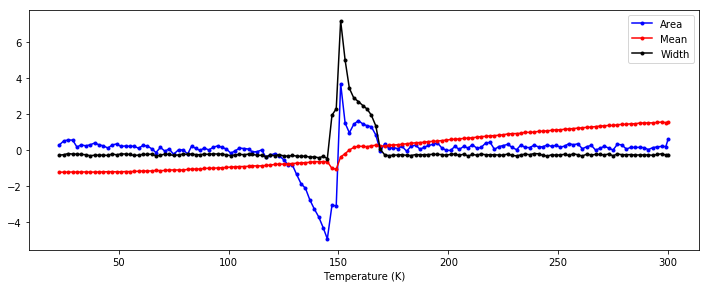

In [13]:
fig = plt.figure(3, figsize=(12,15))

ax1 = plt.subplot(311)
plt.plot(T, AreaNorm, 'b.-', label='Area')
plt.plot(T, MeanNorm, 'r.-', label='Mean')
plt.plot(T, WidthNorm, 'k.-', label='Width')
plt.legend()
plt.xlabel('Temperature (K)')
plt.show()

We can clearly see some interesting structure around T=150 K. Let's study this region more carefully:

In [14]:
phase = [i[0] for i in np.argwhere((T>149)&(T<151))]

In [15]:
T[phase]

array([ 150.99508333])

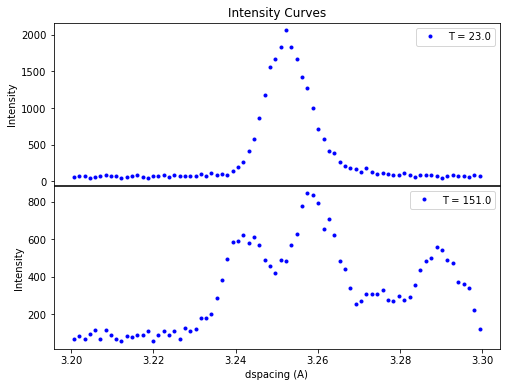

In [16]:
temp = 0

fig = plt.figure(2, figsize=(8,6))
ax1 = plt.subplot(211)
plt.plot(X, Y[temp], 'b.', label='T = {}'.format(round(T[temp], 1) ))
plt.legend()
plt.title('Intensity Curves')
frame = pylab.gca()
frame.axes.get_xaxis().set_ticks([])
plt.ylabel('Intensity')

temp = 64
ax2 = plt.subplot(212)
plt.plot(X, Y[temp], 'b.', label='T = {}'.format(round(T[temp], 1)))
plt.legend()
plt.xlabel('dspacing (A)')
plt.ylabel('Intensity')

plt.subplots_adjust(hspace=.003)

plt.show()

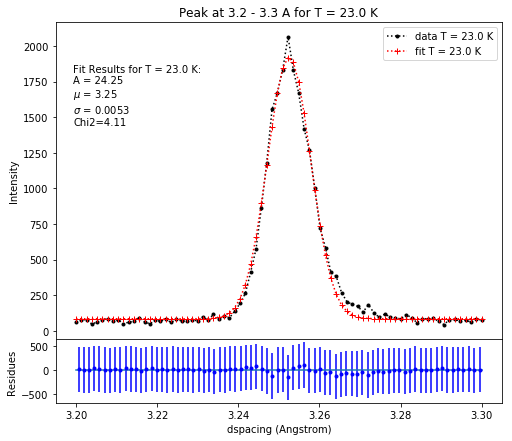

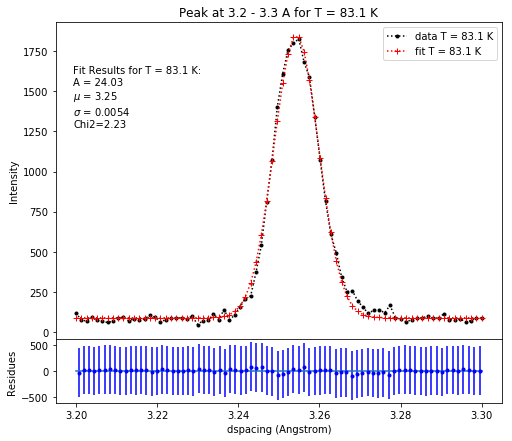

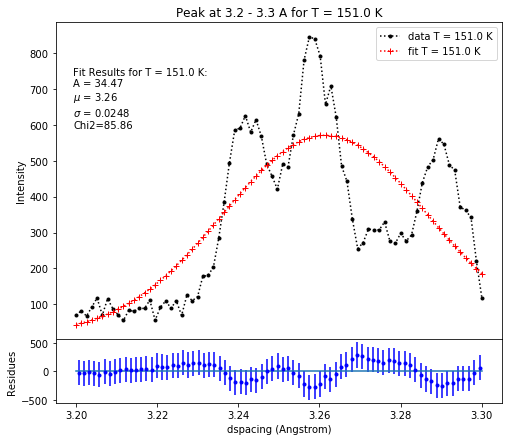

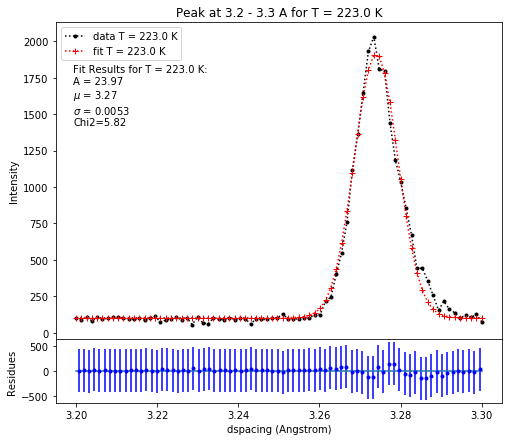

In [17]:
temp = [0, 30, 64, 100]
for itemp in temp:
    TestFit(X, Y[itemp], round(T[itemp], 1))

We can clearly see that the 3.25 A peak structure at $T = 150$ K does not look gausian at all. Therefore the fit fails ( chi2 and residues indicate a problem) and our fitted values for A, c and w are not good. But since we are interested in finding a phase transition temperature we can still use the simple tools developed here so far. We can not trust the value for Area for example, but the value itslef is not important.

The important thing to keep in mind is how to find $T_{transition}$ !

## Peak Detection

Given a temperature T, let's find all the Intensity peaks and characterize them. We find peaks by using the detect_peaks function [1] and characterize them with the gausian fit just like in Q2.

[1] http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

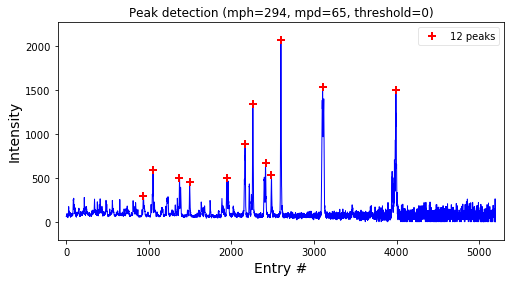

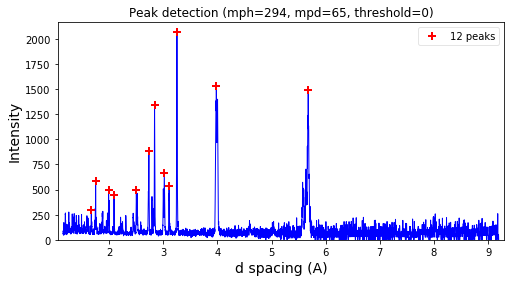

In [18]:
temp = 0
bkg, std = GetBkg(I[temp])
cut = int(bkg + 3.*std)
ind = GetPeaks(I[temp], mph=cut, mpd=65, show=True, scale=ds)

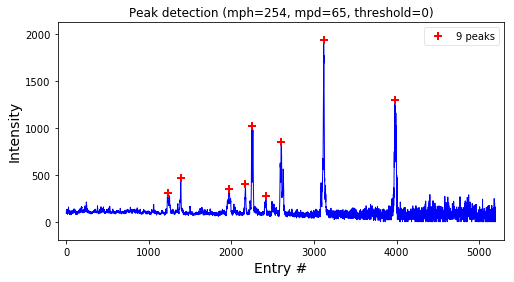

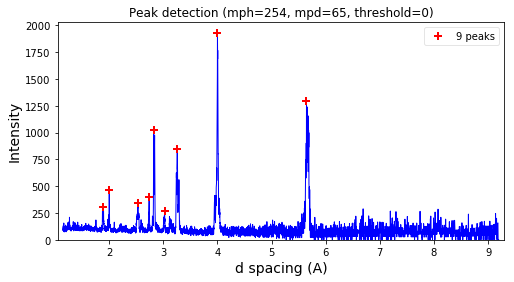

In [19]:
temp = 64
bkg, std = GetBkg(I[temp])
cut = int(bkg + 3.*std)
ind = GetPeaks(I[temp], mph=cut, mpd=65, show=True, scale=ds)

In [21]:
def Pipeline(temp=0, x=ds, show=False):
    # define the data set (x,y) for a given temperature T:
    y = I[temp]
    
    # Find all the Peaks and get the peak's positions:
    bkg, std = GetBkg(y)
    cut = int(bkg + 3.*std)
    inds = GetPeaks(y, mph=cut, mpd=65, show=show, scale=x)
    indsf = []
    for ind in inds:
        fine = True
        for iy in y[ind-10:ind+10]:
            if iy < 5: fine = False
        if fine: indsf.append(ind)
    inds = np.array(indsf)
    # Get all the interesting variables related to each peak:
    areas, means, sigmas, bkgs = GetVars(x, y, inds, bkg)
    npeaks = len(means)
    return npeaks, areas, means, sigmas, bkgs, inds

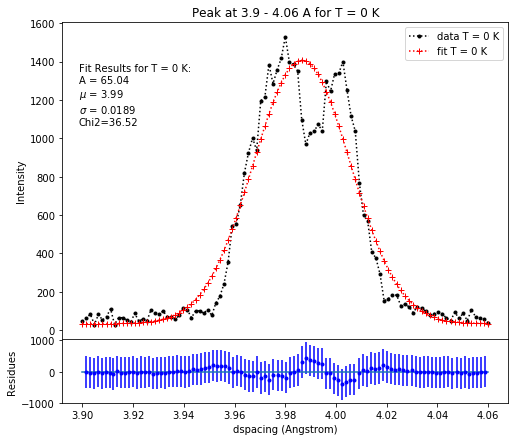

In [22]:
temp = 0
npeaks, areas, means, sigmas, bkgs, inds =  Pipeline(temp=temp)
imin, imax = inds[-2]-50, inds[-2]+50
x, y = ds[imin:imax], I[temp][imin:imax]
TestFit(x, y, temp)

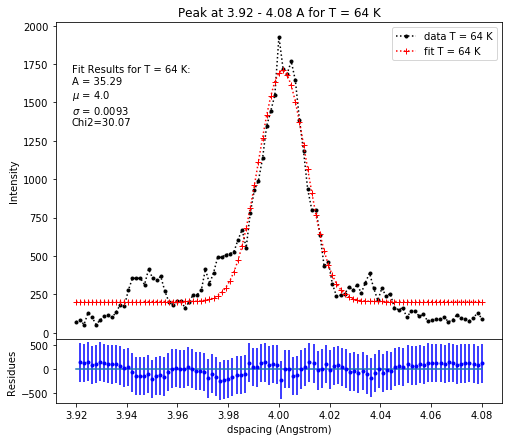

In [23]:
temp = 64
npeaks, areas, means, sigmas, bkgs, inds =  Pipeline(temp=temp)
imin, imax = inds[-2]-50, inds[-2]+50
x, y = ds[imin:imax], I[temp][imin:imax]
TestFit(x, y, temp)

## Phase Transition

The idea here will be to apply the method developed so far. We first detect all the peaks and characterize them for a given temperature T and also the adjacent neighbor.
Once we have a list of all the peaks (containing areas, centers and widths) we can compare both lists and check if a phase transition occured between these temperatures.

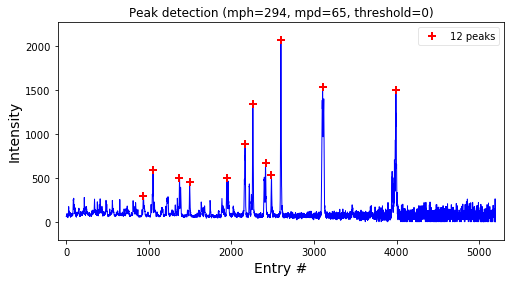

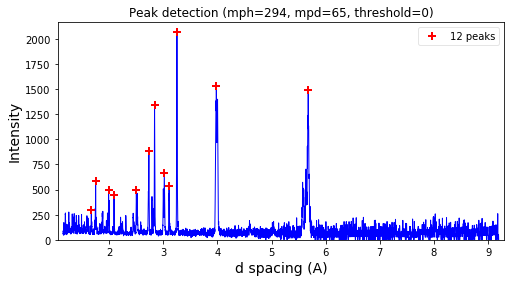

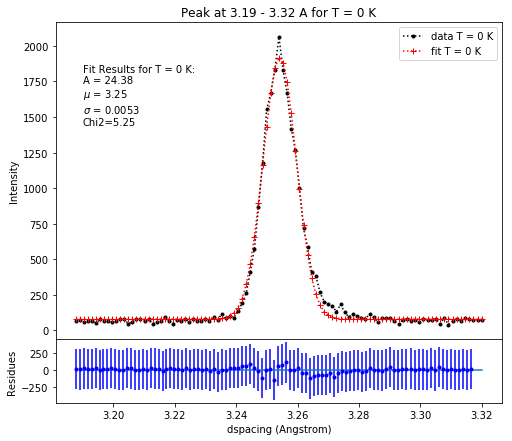

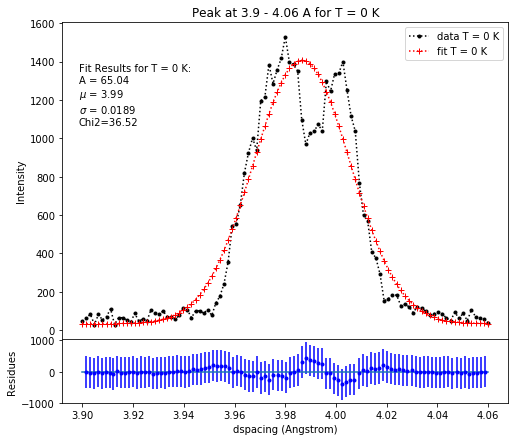

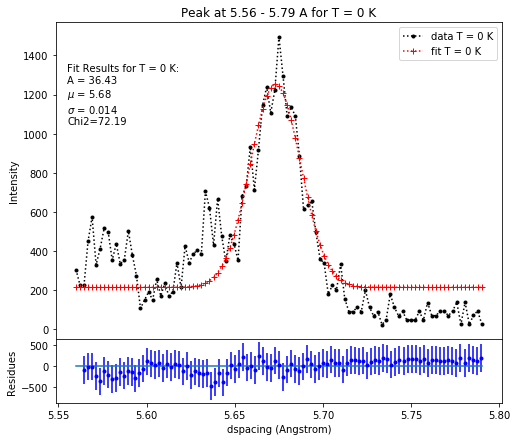

In [24]:
temp = 0
npeaks, areas, means, sigmas, bkgs, inds =  Pipeline(temp=temp, show=True)
imin, imax = inds[9]-50, inds[9]+50
x, y = ds[imin:imax], I[temp][imin:imax]
TestFit(x, y, temp)
imin, imax = inds[10]-50, inds[10]+50
x, y = ds[imin:imax], I[temp][imin:imax]
TestFit(x, y, temp)
imin, imax = inds[-1]-50, inds[-1]+50
x, y = ds[imin:imax], I[temp][imin:imax]
TestFit(x, y, temp)

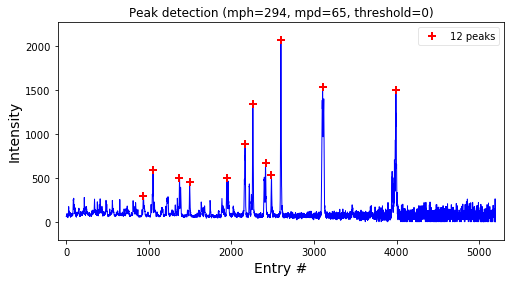

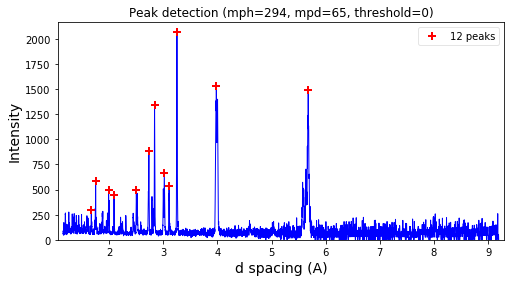

In [25]:
temp=0
y = I[temp]
bkg, std = GetBkg(y)
cut = int(bkg + 3.*std)
inds = GetPeaks(y, mph=cut, mpd=65, show=True, scale=ds)

In [26]:
deltan = []
deltam = []
Tm = []
for temp, iT in enumerate(T[:-1]):
    npeaks, areas, means, sigmas, bkgs, inds =  Pipeline(temp=temp, show=False, x=ds)
    npeaks2, areas2, means2, sigmas2, bkgs2, inds2 =  Pipeline(temp=temp+1, show=False, x=ds)
    deltan.append(npeaks - npeaks2)
    if npeaks - npeaks2 == 0:
        for m1, m2 in zip(means, means2):
            deltam.append(m1-m2)
            Tm.append(iT)
"""    for i, m1 in enumerate(means):
        for j, m2 in enumerate(means2):
            if abs(m2-m1)
    for a1 in areas:
"""

'    for i, m1 in enumerate(means):\n        for j, m2 in enumerate(means2):\n            if abs(m2-m1)\n    for a1 in areas:\n'

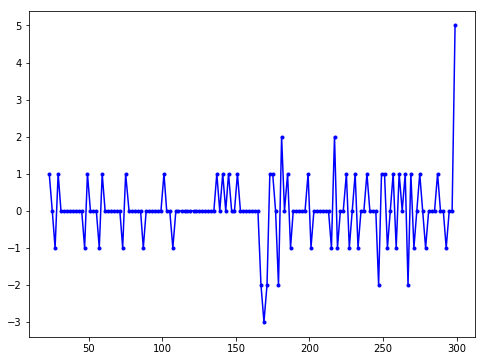

In [27]:
fig = plt.figure(1, figsize=(8,6))
ax1 = plt.subplot(111)
plt.plot(T[:-1], deltan, 'b.-')
plt.show()

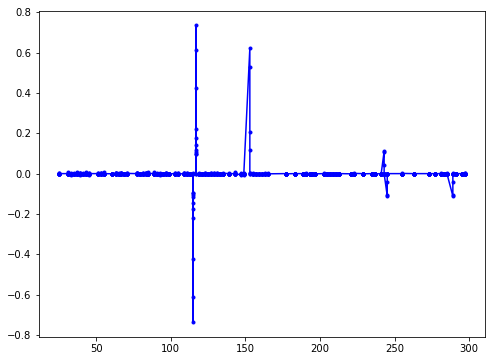

In [28]:
fig = plt.figure(1, figsize=(8,6))
ax1 = plt.subplot(111)
plt.plot(Tm, deltam, 'b.-')
plt.show()

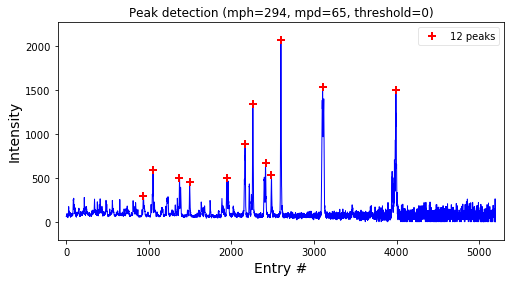

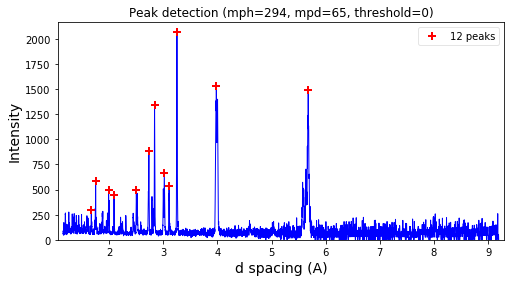

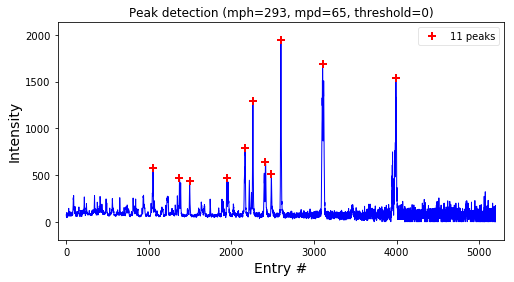

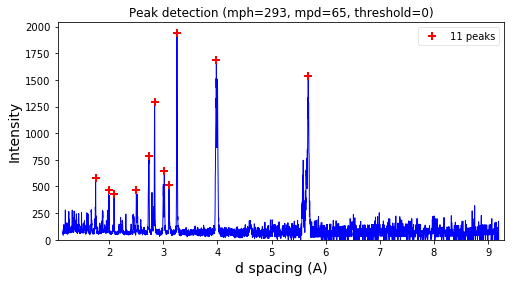

0.8410007953643799


In [29]:
tic = time.time()
temp = 0
npeaks, areas, means, sigmas, bkgs, inds =  Pipeline(temp=temp, show=True)
npeaks, areas, means, sigmas, bkgs, inds =  Pipeline(temp=temp+1, show=True)
toc = time.time()
print(toc - tic)

In [ ]:
X, Y, AreaPeak, MeanPeak, WidthPeak, BkgPeak, AvgPeak, LSEPeak = CharacterizePeaks(5.5, 5.8)

In [ ]:
fig = plt.figure(5, figsize=(12,18))

ax1 = plt.subplot(511)
plt.plot(T, AreaPeak, 'b.-', label='Area')
plt.legend()
plt.title('Area under the 3.25 A Peak vs Temperature (K)')
plt.xlabel('Temperature (K)')
plt.ylabel('Area under the 3.25 A Peak')
plt.setp(ax1.get_xticklabels(), fontsize=10)

ax2 = plt.subplot(512, sharex=ax1)
plt.plot(T, MeanPeak, 'r.-', label='Mean')
plt.legend()
plt.title('Mean of the 3.25 A Peak vs Temperature (K)')
plt.xlabel('Temperature (K)')
plt.ylabel('Mean of the 3.25 A Peak')

ax3 = plt.subplot(513, sharex=ax1)
plt.plot(T, WidthPeak, 'k.-', label='Width')
plt.legend()
plt.title('Width of the 3.25 A Peak vs Temperature (K)')
plt.xlabel('Temperature (K)')
plt.ylabel('Width of the 3.25 A Peak')

ax4 = plt.subplot(514, sharex=ax1)
plt.plot(T, BkgPeak, 'g.-', label='Background')
plt.plot(T, AvgPeak, 'y.-', label='Average <3.24')
plt.legend()
plt.title('Background level around the 3.25 A Peak vs Temperature (K)')
plt.xlabel('Temperature (K)')
plt.ylabel('Background level around the 3.25 A Peak')

ax5 = plt.subplot(515, sharex=ax1)
plt.plot(T, LSEPeak, '.-', label='LSE')
plt.legend()
plt.title('Least Squares for the 3.25 A Peak vs Temperature (K)')
plt.xlabel('Temperature (K)')
plt.ylabel('LSE')

plt.tight_layout()
plt.show()